# Simulate observables through the atmosphere

This notebook shows how the ground-based observations with photonic lanterns look like, affected by the atmospheric turbulence.

We'll simulate the atmosphere using `hcipy`.

In [82]:
import hcipy as hc
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Define pupil grid
ndim = 65
diameter = 10
pupil_grid = hc.make_pupil_grid(ndim, diameter)
ref_wavelength = 1.55e-6

# Define focal grid
focal_plane_resolution = 0.5e-6  # 0.5 micron per pixel
focal_length = diameter * 5 # focal ratio of 5
focal_grid = hc.make_pupil_grid(ndim, focal_plane_resolution * ndim)

# Define aperture and wavefront
aperture = hc.make_circular_aperture(diameter)(pupil_grid)
wf = hc.Wavefront(aperture, ref_wavelength)

# Define propagator
prop = hc.FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

Let's prepare the device (standard 6-port lantern) and the scene.

In [84]:
from PLsim.otf import OTF
from PLsim.scene import Scene, SceneProjector
from PLsim.system.device import Device

# Define PL multimode entrance parameters (changing this would change the number of guided modes)
ncore = 1.444
nclad = 1.444 - 5.5e-3
rcore = 10e-6 # meters

otf = OTF.from_fiber_params(ncore, nclad, rcore, ref_wavelength,
                            focal_grid, pupil_grid, focal_length,
                            aperture, optimize_focal_length = False)

otf.compute()

from PLsim.system.lantern import generate_unitary_matrix

nwav = 21
matrix  = generate_unitary_matrix(6)[np.newaxis,:,:].repeat(nwav, axis=0)

# Define the device
device = Device(matrix)

# Define the scene
scene = Scene(pupil_grid, ref_wavelength)
scene_projector = SceneProjector(otf, scene)

# This takes some time and memory!! 
fov = 50e-3/206265
ngrid = 32
out_grid = scene_projector.compute_point_grid(fov, ngrid)

Supported modes:  ['LP01', 'LP11a', 'LP11b', 'LP21a', 'LP21b', 'LP02']
Number of modes:  6
Device initialized with:
  Lantern matrices: (21, 6, 6)
  PIC matrices: None
  Wavelengths: 21


Load the image (see [simulate_lantern_spectra](./1_simulate_PL_spectra.ipynb)).

In [85]:
images = np.load('disk_images.npy')
vgrid = np.linspace(-300, 300, nwav) # km/s, used for simulation of the images

# because the image is 64x64, I'll bin this into the correct grid size, 32x32
images_binned = images.reshape((nwav, ngrid, 2, ngrid, 2)).sum(axis=(2,4))

In [86]:
disk_outs = device.calculate_outputs(scene_projector.compute_scene_from_image(images_binned))

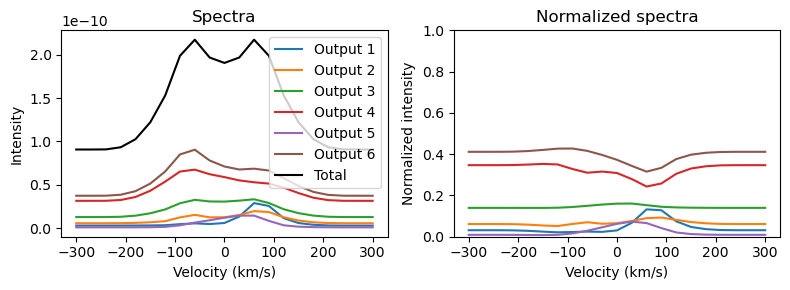

In [87]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
for i in range(6):
    axs[0].plot(vgrid, disk_outs[:,i], label=f'Output {i+1}')
    axs[1].plot(vgrid, disk_outs[:,i]/np.sum(disk_outs,axis=1))

axs[0].plot(vgrid, np.sum(disk_outs, axis=1), label='Total', color='k')
axs[0].set_title('Spectra')
axs[1].set_title('Normalized spectra')
axs[0].set_xlabel('Velocity (km/s)')
axs[1].set_xlabel('Velocity (km/s)')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Normalized intensity')
axs[0].legend()
axs[1].set_ylim([0, 1])
fig.tight_layout()
plt.show()

Now pass through turbulence.

In practice we will be dealing with adaptive optics (AO)-corrected wavefront, so nearly diffraction-limited. The parameters are adjusted to make it look reasonable for ExAO...

In [88]:
seeing = 0.07 # arcsec 
outer_scale = 40 # meter
tau0 = 0.005 # seconds

fried_parameter = hc.atmosphere.seeing_to_fried_parameter(seeing)
Cn_squared = hc.atmosphere.Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
velocity = 0.314 * fried_parameter / tau0

layer = hc.atmosphere.InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

Text(0.5, 1.0, 'Phase screen')

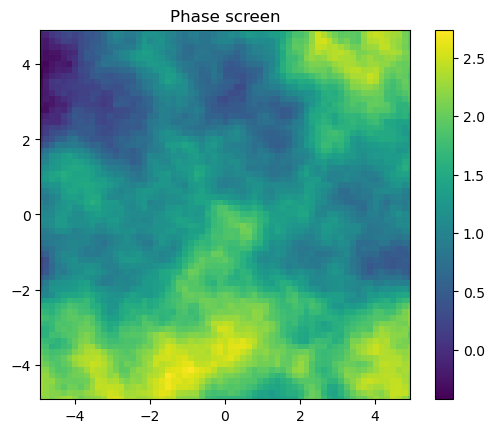

In [89]:
hc.imshow_field(layer.phase_for(ref_wavelength))
plt.colorbar()
plt.title('Phase screen')

This is how the instantaneous PSF looks like

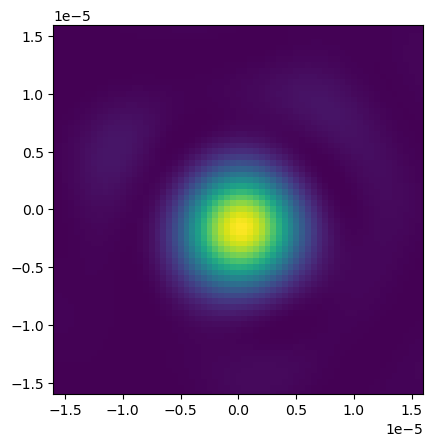

In [90]:
wf_focal = prop(layer(wf))
hc.imshow_field(wf_focal.intensity)

Wavefront aberration in `PLsim` is implemented in the OTF matrix layer. The cross-correlation of pupil functions need to be re-calculated. This is done through `OTF.aberrate` method.

In [91]:
otf.aberrate(layer.phase_for(ref_wavelength))

Need to recompute the grid response.

In [92]:
out_grid_aber = scene_projector.compute_point_grid(fov, ngrid)

Now the lantern outputs with the aberration

In [93]:
disk_outs2 = device.calculate_outputs(scene_projector.compute_scene_from_image(images_binned))

Make the same plot!

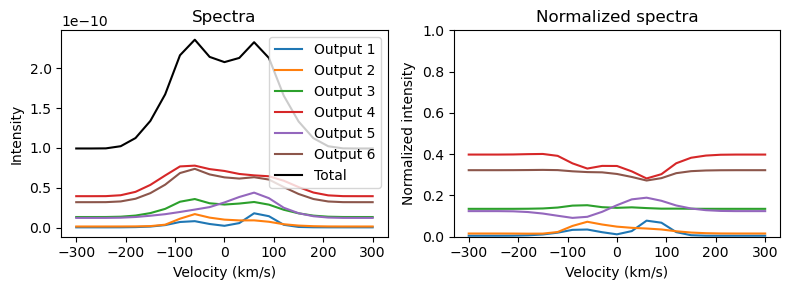

In [94]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
for i in range(6):
    axs[0].plot(vgrid, disk_outs2[:,i], label=f'Output {i+1}')
    axs[1].plot(vgrid, disk_outs2[:,i]/np.sum(disk_outs2,axis=1))

axs[0].plot(vgrid, np.sum(disk_outs2, axis=1), label='Total', color='k')
axs[0].set_title('Spectra')
axs[1].set_title('Normalized spectra')
axs[0].set_xlabel('Velocity (km/s)')
axs[1].set_xlabel('Velocity (km/s)')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Normalized intensity')
axs[0].legend()
axs[1].set_ylim([0, 1])
fig.tight_layout()
plt.show()

With the aberration, the spectral shape changed.

Let's animate the effects of time-varying aberration.

In [95]:
# carefully choose this. it takes ~ 1s per simulation with my laptop
nsim = 50

dt = 0.02 # 20 ms

In [96]:
PSFs = []
results = []

for iter in range(nsim):
    layer.t += dt

    wf_focal = prop(layer(wf))
    otf.aberrate(layer.phase_for(ref_wavelength))
    out_grid_aber = scene_projector.compute_point_grid(fov, ngrid)
    disk_outs2 = device.calculate_outputs(scene_projector.compute_scene_from_image(images_binned))

    PSFs.append(wf_focal.intensity)
    results.append(disk_outs2)

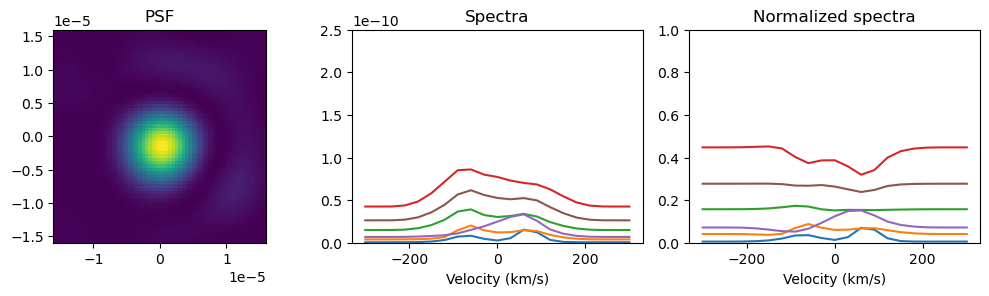

In [97]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig, axs = plt.subplots(ncols=3, figsize=(10,3))


def animate(ind):
    for ax in axs: ax.clear()

    hc.imshow_field(PSFs[ind], ax = axs[0])

    for i in range(6):
        axs[1].plot(vgrid, results[ind][:,i], label=f'Output {i+1}')
        axs[2].plot(vgrid, results[ind][:,i]/np.sum(results[ind],axis=1))

    axs[1].set_ylim([0, 2.5e-10])
    axs[2].set_ylim([0, 1])
    fig.tight_layout()
    axs[0].set_title('PSF')
    axs[1].set_title('Spectra')
    axs[2].set_title('Normalized spectra')
    axs[1].set_xlabel('Velocity (km/s)')
    axs[2].set_xlabel('Velocity (km/s)')
anim = FuncAnimation(fig, animate, range(nsim), interval = 100)
HTML(anim.to_html5_video())


It fluctuates a lot! 

Let's look at the long-exposure spectra. This is average of 50 frames with 20 ms cadence, so total 1 second exposure.

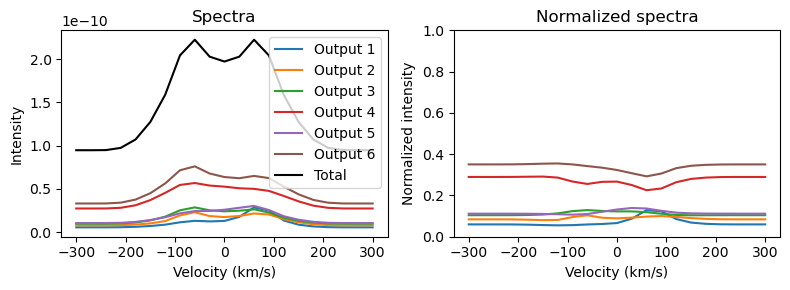

In [98]:
averaged_spectra = np.mean(np.array(results), axis=0)

fig, axs = plt.subplots(ncols=2, figsize=(8,3))
for i in range(6):
    axs[0].plot(vgrid, averaged_spectra[:,i], label=f'Output {i+1}')
    axs[1].plot(vgrid, averaged_spectra[:,i]/np.sum(averaged_spectra,axis=1))

axs[0].plot(vgrid, np.sum(averaged_spectra, axis=1), label='Total', color='k')
axs[0].set_title('Spectra')
axs[1].set_title('Normalized spectra')
axs[0].set_xlabel('Velocity (km/s)')
axs[1].set_xlabel('Velocity (km/s)')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Normalized intensity')
axs[0].legend()
axs[1].set_ylim([0, 1])
fig.tight_layout()
plt.show()

The features in normalized spectra are smoothed out.

To remove aberration, do `otf.unaberrate`

In [99]:
otf.unaberrate()